In [21]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13/struct1'
os.chdir(new_path)


In [22]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy


### Helper functions

In [23]:
def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def plot_atomic_positions_by_species(atoms, element_colors):
    fig, ax = plt.subplots(figsize=(10, 3))
    positions = atoms.positions
    x = positions[:, 0]
    y = positions[:, 1]

    colors = [element_colors[atom.symbol] for atom in atoms]

    ax.scatter(x, y, color=colors, s=300)

    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), color='black', fontsize=9, ha='center', va='center')


    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_title('Atomic Positions by Species')

    plt.show()

In [24]:
def create_active_hamiltonian(H_cutcoupled, S_cutcoupled, index_left_Au, index_right_Au,  index_active_region):
    """
    Create the Hamiltonian H_active by retaining the left and right Au orbitals and
    the active region couplings within the bridge.

    Parameters:
    H_cutcoupled (np.ndarray): The Hamiltonian matrix after cutting couplings.
    index_active_region (list of int): Indices of the active orbitals within the bridge.

    Returns:
    np.ndarray: The Hamiltonian matrix H_active.
    """

    # Create a list of indices to retain
    indices_to_keep = index_left_Au + sorted(list(index_active_region)) + index_right_Au

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H_cutcoupled[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S_cutcoupled[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active[None,...], S_active[None,...]


### Control parameters

In [25]:
GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [26]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [27]:
lowdin = True
cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao


Condition number: 2.7e+04


In [28]:
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

In [29]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-2., 2. + de / 2., de).round(7)
eta = 1e-3

# Define the path to the reference data for transmission
ref_path = "published_reference/transmission"

# Load the reference LCAO transmission data from a file, where reference is the data from "Smart Local Orbitals paper"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_Cpz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_Cpzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

In [30]:
# Define energy range and broadening factor for the Green's function calculation
de = 0.2
energies = np.arange(-2., 2. + de / 2., de).round(7)
eta = 1e-3

In [31]:
# Define the path to the reference data for transmission
ref_path = "published_reference/transmission"

# Load the reference LCAO transmission data from a file, where reference is the data from "Smart Local Orbitals paper"
Tref_lcao = np.loadtxt(f"{ref_path}/ET_hs.dat")
Tref_Cpz = np.loadtxt(f"{ref_path}/ET_pz.dat")
Tref_Cpzd = np.loadtxt(f"{ref_path}/ET_pzd.dat")

### Get right nodes

In [32]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal_for_nodes = rotate_matrix(H_lcao, Usub)[None, ...]
nodes = graph_partition.get_tridiagonal_nodes(
    device_basis,
    H_subdiagonal_for_nodes[0],
    len(leads_atoms.repeat(Nr))
)
# Define the indices for left Au and right Au based on the nodes
index_left_Au = list(range(nodes[0], nodes[2]))  # From 0 to end of left Au region
index_right_Au = list(range(nodes[3], nodes[-1]))  # From start of right Au region to the end

### Subdiagonalize C  of LCAO Hamiltonian (Hamiltonian obtained directly from gpaw)

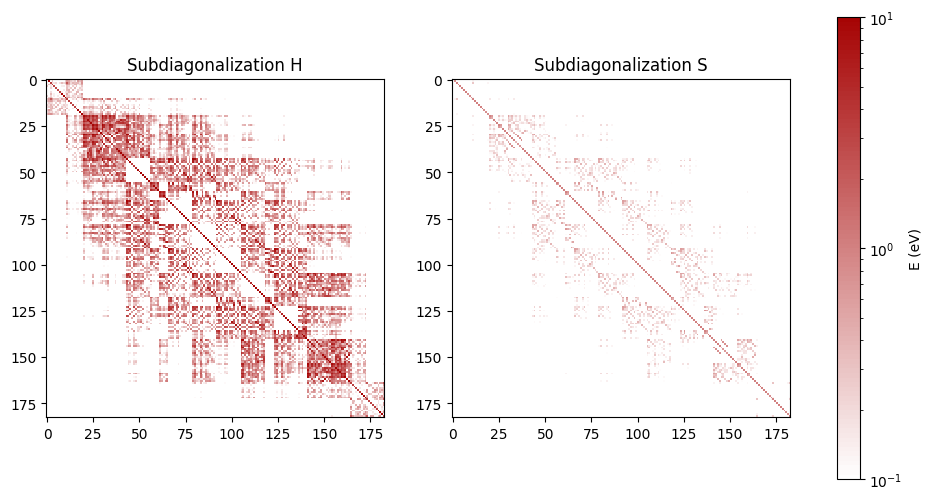

In [33]:
# Perform subdiagonalization
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao, Usub)[None, ...]
S_subdiagonal = rotate_matrix(S_lcao, Usub)[None, ...]

# Extract the bridge regions
bridge_region_H_sub = H_subdiagonal[0, bridge_start-20:bridge_end+20, bridge_start-20:bridge_end+20]
bridge_region_S_sub = S_subdiagonal[0, bridge_start-20:bridge_end+20, bridge_start-20:bridge_end+20]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalization H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalization S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()


### Use C to subdiagonalize and look at the effect of cut-coupling where C 2 pz and N lcao orbitals are considered to be the active region 

[0, 810, 1116, 1148, 1454, 2264]


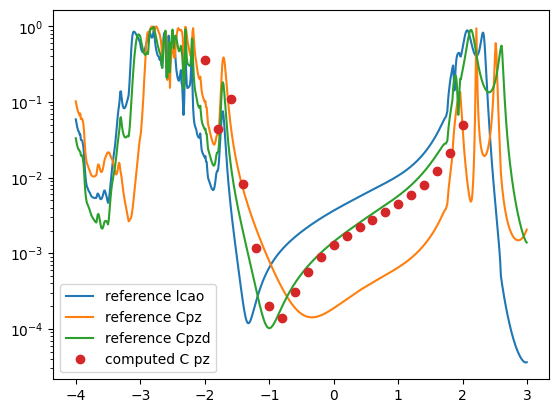

In [34]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_sudiagonalized)
S_cutcoupled = deepcopy(S_sudiagonalized)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3}#, 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)


# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_cutcoupled)
remove_pbc(device_basis, S_cutcoupled)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

nodes_active = [0,810,1116,1148,1454,2264]

# Print the nodes to verify the partitioning
print(nodes_active)

# Add N orbitals to the active space
N_indices = get_species_indices(atoms, ("N"))
basis_N_region = basis[N_indices]
index_N_region = basis_N_region.get_indices()
relevant_index = list(index_active_region) + list(index_N_region)

H_active, S_active = create_active_hamiltonian(H_cutcoupled[0], S_cutcoupled[0], index_left_Au, index_right_Au, relevant_index)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes_active,
    H_active[0],
    S_active[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point


# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed C pz")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")

plt.legend()

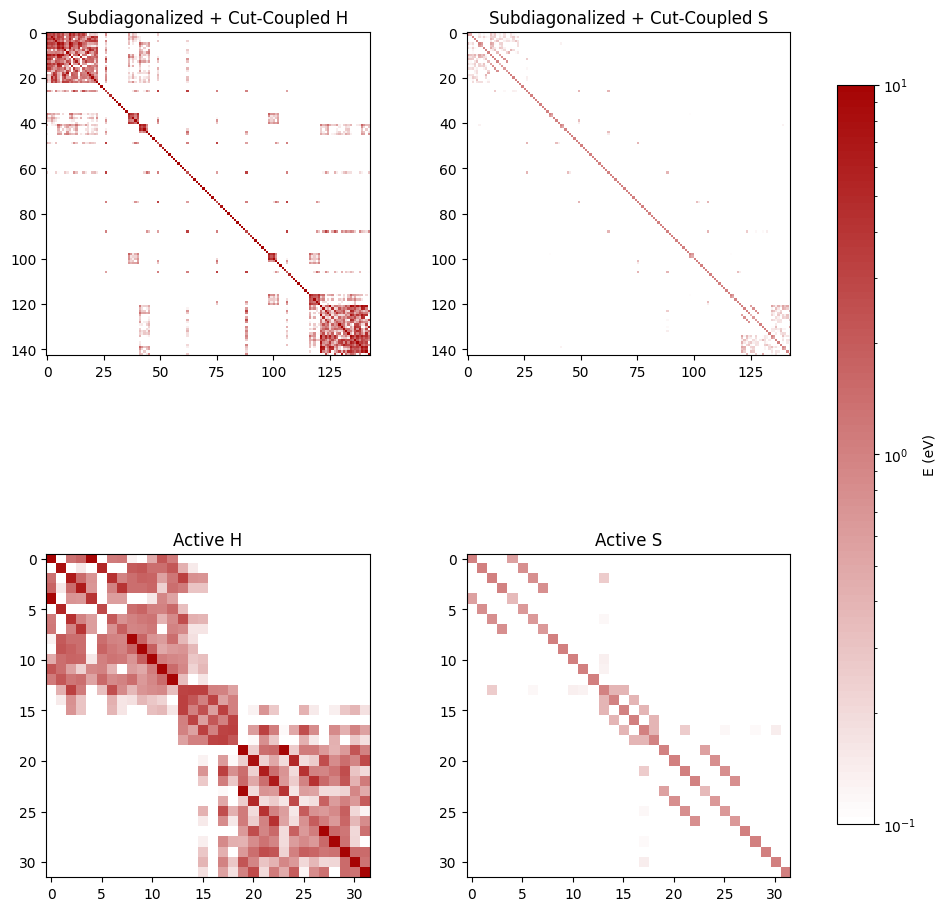

In [35]:
from matplotlib import gridspec

# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled[0, bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_cut = S_cutcoupled[0, bridge_start:bridge_end, bridge_start:bridge_end]

# Define the region for the active matrices
active_H = H_active[0, 1116:1148, 1116:1148]
active_S = S_active[0, 1116:1148, 1116:1148]

# Create a figure with a grid spec layout
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
ax2 = fig.add_subplot(gs[0, 1])
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Plot the subdiagonalized + cut-coupled Hamiltonian for the active region
ax3 = fig.add_subplot(gs[1, 0])
cax3 = ax3.imshow(np.abs(active_H), interpolation='nearest', cmap=cm, norm=norm)
ax3.set_title("Active H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the active region
ax4 = fig.add_subplot(gs[1, 1])
cax4 = ax4.imshow(np.abs(active_S), interpolation='nearest', cmap=cm, norm=norm)
ax4.set_title("Active S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=[ax1, ax2, ax3, ax4], orientation='vertical', shrink=0.8, aspect=20)
cbar.set_label('E (eV)')

# Display the plots
plt.show()


### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C 2pz and all N orbitals are considered to be the active region. 

[0, 810, 1116, 1148, 1454, 2264]


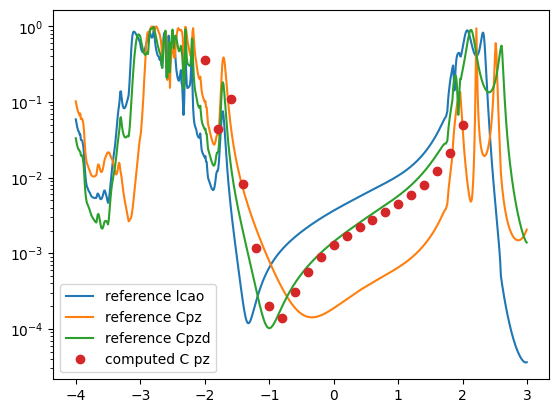

In [36]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C","N","H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_subdiagonal = rotate_matrix(H_lcao, Usub)[None, ...]
S_subdiagonal = rotate_matrix(S_lcao, Usub)[None, ...]

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species
active = {'C': 3, 'N': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}
extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

relevant_index = list(index_active_region)

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Prepare the k-points and matrices for the leads using the cut-coupled Hamiltonian matrix
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_subdiagonal[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device matrices
remove_pbc(device_basis, H_subdiagonal)
remove_pbc(device_basis, S_subdiagonal)

# Initialize self-energy list for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_subdiagonal)
S_cutcoupled = deepcopy(S_subdiagonal)


# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)

H_active, S_active = create_active_hamiltonian(H_cutcoupled[0], S_cutcoupled[0], index_left_Au, index_right_Au, relevant_index)

nodes_active = [0,810,1116,1148,1454,2264]

# Print the nodes to verify the partitioning
print(nodes_active)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes_active,
    H_active[0],
    S_active[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point


# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed C pz")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")

plt.legend()

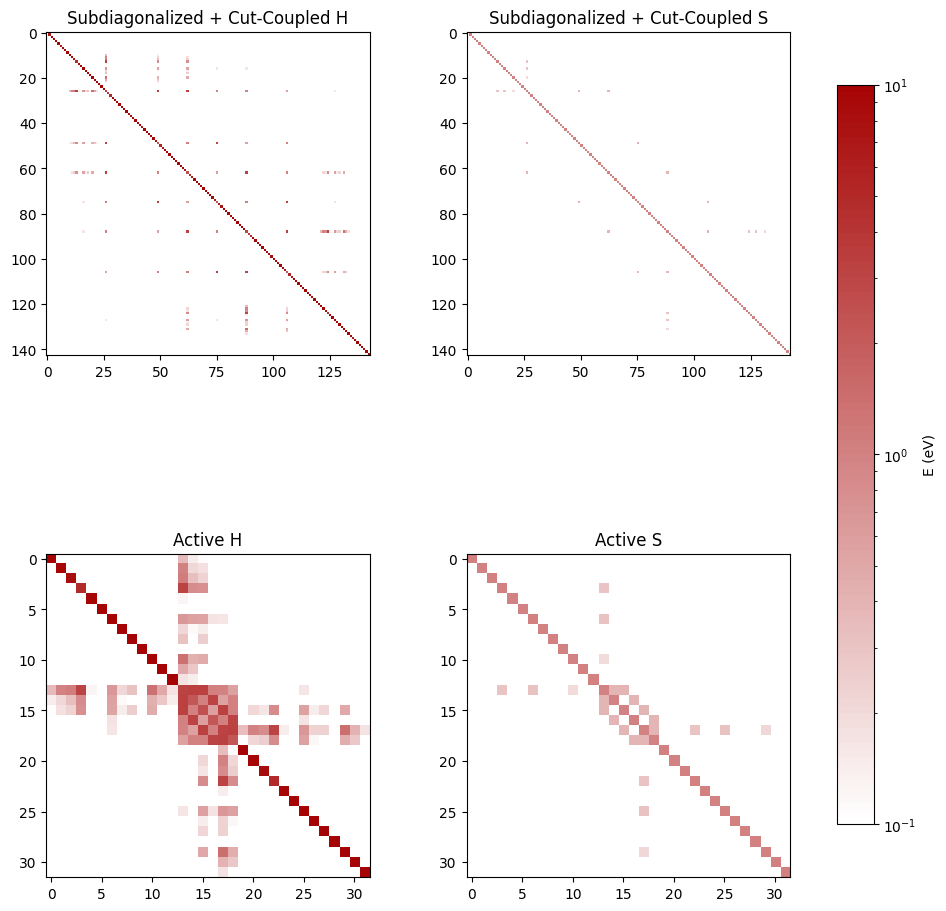

In [37]:
# Extract the bridge region from the cut-coupled Hamiltonian and overlap matrices
bridge_region_H_cut = H_cutcoupled[0, bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_cut = S_cutcoupled[0, bridge_start:bridge_end, bridge_start:bridge_end]

# Define the region for the active matrices
active_H = H_active[0, 1116:1148, 1116:1148]
active_S = S_active[0, 1116:1148, 1116:1148]

# Create a figure with a grid spec layout
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

# Plot the subdiagonalized + cut-coupled Hamiltonian for the bridge region
ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(np.abs(bridge_region_H_cut), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized + Cut-Coupled H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the bridge region
ax2 = fig.add_subplot(gs[0, 1])
cax2 = ax2.imshow(np.abs(bridge_region_S_cut), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized + Cut-Coupled S")

# Plot the subdiagonalized + cut-coupled Hamiltonian for the active region
ax3 = fig.add_subplot(gs[1, 0])
cax3 = ax3.imshow(np.abs(active_H), interpolation='nearest', cmap=cm, norm=norm)
ax3.set_title("Active H")

# Plot the subdiagonalized + cut-coupled overlap matrix for the active region
ax4 = fig.add_subplot(gs[1, 1])
cax4 = ax4.imshow(np.abs(active_S), interpolation='nearest', cmap=cm, norm=norm)
ax4.set_title("Active S")

# Add a shared colorbar for all subplots
cbar = fig.colorbar(cax4, ax=[ax1, ax2, ax3, ax4], orientation='vertical', shrink=0.8, aspect=20)
cbar.set_label('E (eV)')

# Display the plots
plt.show()


### Proceed with using C,N,H to subdiagonalize and look at the effect of cut-coupling where C pzd and all N orbitals are considered to be the active region 

In [38]:
# Define indices for external and internal carbon atoms and the active orbitals for each set
external_C_indices = [127, 133]  # Indices of external carbon atoms
internal_C_indices = [130, 131, 132, 135]  # Indices of internal carbon atoms
kind = 'C'  # Atom type (Carbon)
active_ext_C = {kind: [3, 6, 7, 10, 12]}  # Active orbitals for external carbon atoms
active_int_C = {kind: [3, 6, 10, 12]}  # Active orbitals for internal carbon atoms

# Search for all atoms of the specified kind (Carbon) in the atomic structure
search_result = atoms.symbols.search(kind)

# Compute cumulative sum of the number of atomic orbitals for each atom, used for indexing
M_a = np.cumsum(np.insert(nao_a[:-1], 0, 0))

# Initialize an empty list to store the indices of the selected active orbitals
idxlist = []

# Loop over each atom found in the search result
for a in search_result:
    if a in external_C_indices:
        # If the atom is in the external carbon indices, add the active external orbitals to the list
        idxlist.extend(M_a[a] + np.array(active_ext_C[kind]))
    elif a in internal_C_indices:
        # If the atom is in the internal carbon indices, add the active internal orbitals to the list
        idxlist.extend(M_a[a] + np.array(active_int_C[kind]))

# Convert the list of indices to a NumPy array
idxlist = np.asarray(idxlist)

# Sort the list of indices to ensure proper order
idxlist.sort()

[0, 810, 1116, 1168, 1474, 2284]


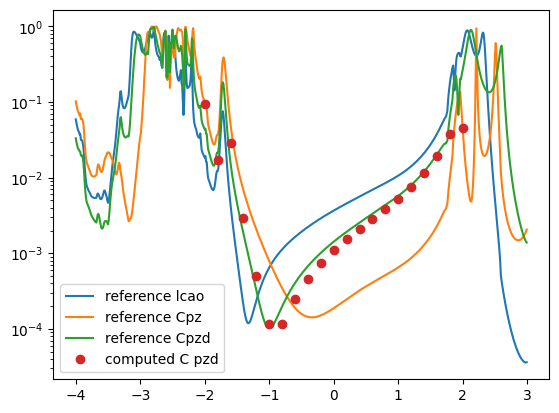

In [44]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_sudiagonalized)
S_cutcoupled = deepcopy(S_sudiagonalized)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

# Define the active region within the subdiagonalized species (for Nitrogen in this case)
active_N = {'N': [0,1,2,3,4,5,6,7,8,9,10,11,12]}
extract_active_region = basis_subdiag_region.extract().take(active_N)
index_active_region = index_subdiag_region[extract_active_region]


# Concatenate the previously obtained idxlist with the new active region indices and sort them
index_active_region = np.concatenate((idxlist, index_active_region))
relevant_index = index_active_region

index_active_region.sort()
# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)
# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)
# Prepare the k-points and Hamiltonian/overlap matrices for the leads based on the cut-coupled device Hamiltonian
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled[0, 0, 0]))
# Remove periodic boundary conditions (PBC) from the cut-coupled device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_cutcoupled)
remove_pbc(device_basis, S_cutcoupled)
# Initialize the self-energy matrices for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)
# Rotate the couplings for the left and right leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)
# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_subdiagonal)
S_cutcoupled = deepcopy(S_subdiagonal)
# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)
H_active, S_active = create_active_hamiltonian(H_cutcoupled[0], S_cutcoupled[0], index_left_Au, index_right_Au, relevant_index)

nodes_active = [0,810,1116,1168,1474,2284]
# Print the nodes to verify the partitioning
print(nodes_active)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes_active,
    H_active[0],
    S_active[0]
)
# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)
# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)
# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point
# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")
# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed C pzd")
# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.legend()

[0, 810, 1116, 1168, 1474, 2284]


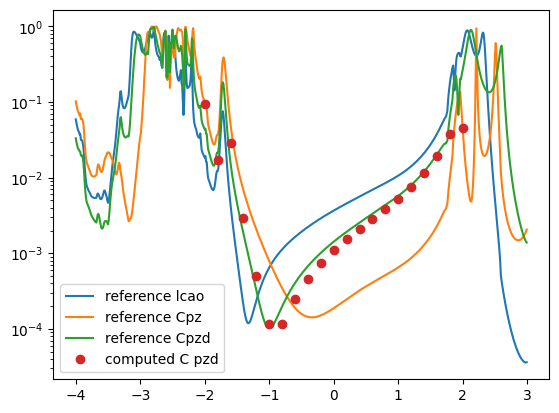

In [45]:
# Define species for subdiagonalization and get their indices in the atom basis
SUBDIAG_SPECIES = ("C")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

# Perform subdiagonalization on the Hamiltonian and overlap matrices
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)

# Rotate the matrices using the subdiagonalization matrix
H_sudiagonalized = rotate_matrix(H_lcao, Usub)[None, ...]
S_sudiagonalized = rotate_matrix(S_lcao, Usub)[None, ...]

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_sudiagonalized)
S_cutcoupled = deepcopy(S_sudiagonalized)

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()
index_active_region = idxlist

# Add N orbitals to the active space
N_indices = get_species_indices(atoms, ("N"))
basis_N_region = basis[N_indices]
index_N_region = basis_N_region.get_indices()
relevant_index = list(index_active_region) + list(index_N_region)

# Determine the indices of the inactive region (outside the active set)
active_set = set(index_active_region)
index_inactive_region = [idx for idx in index_subdiag_region if idx not in active_set]
index_inactive_region = list(index_inactive_region)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)

# Prepare the k-points and Hamiltonian/overlap matrices for the leads based on the cut-coupled device Hamiltonian
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_cutcoupled[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the cut-coupled device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_cutcoupled)
remove_pbc(device_basis, S_cutcoupled)

# Initialize the self-energy matrices for the left and right leads
self_energy = [None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t,
    (h_leads_kii, s_leads_kii),
    (h_leads_kij, s_leads_kij),
    Nr=Nr,
    id='right'
)

# Rotate the couplings for the left and right leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Create deep copies of the subdiagonalized matrices for further modification
H_cutcoupled = deepcopy(H_subdiagonal)
S_cutcoupled = deepcopy(S_subdiagonal)

# Cut the couplings in the inactive region
cutcoupling(H_cutcoupled[0], S_cutcoupled[0], index_inactive_region)
H_active, S_active = create_active_hamiltonian(H_cutcoupled[0], S_cutcoupled[0], index_left_Au, index_right_Au, relevant_index)

nodes_active = [0,810,1116,1168,1474,2284]

# Print the nodes to verify the partitioning
print(nodes_active)


# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(
    nodes_active,
    H_active[0],
    S_active[0]
)

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(
    hs_list_ii,
    hs_list_ij,
    [
        (0, self_energy[0]),  # Attach the left self-energy at the first node
        (len(hs_list_ii) - 1, self_energy[1])  # Attach the right self-energy at the last node
    ],
    solver='coupling',
    eta=eta
)

# Initialize an array to store the transmission values for each energy
T = np.empty(energies.size)

# Calculate the transmission function T for each energy in the defined range
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point

# Plot the reference LCAO transmission data
plt.plot(Tref_lcao[:,0], Tref_lcao[:,1], label="reference lcao")
plt.plot(Tref_Cpz[:,0], Tref_Cpz[:,1], label="reference Cpz")
plt.plot(Tref_Cpzd[:,0], Tref_Cpzd[:,1], label="reference Cpzd")

# Plot the computed LCAO transmission data
plt.plot(energies, T, 'o', label="computed C pzd")

# Set the y-axis to a logarithmic scale to better visualize the transmission data
plt.yscale("log")
plt.legend()